# Outliers

An outlier is a data point that is significantly different from the remaining data.

"An outlier is an observation that deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism." [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980.]

## Should outliers be removed?

Depending on the context, outliers either deserve special attention or should be ignored. Take the example of revenue forecasting: if unusual spikes of revenue are observed, it's probably a good idea to pay extra attention to them and figure out what caused the spike. In the same way, an unusual transaction on a credit card might be a sign of fraudulent activity, which is what the credit card issuer wants to prevent. So, in instances like these, it is useful to look for and investigate further the outlier values.

If outliers are, however, introduced by mechanical or measurement error, it is a good idea to remove these outliers before training the model. Why? because some algorithms are sensitive to outliers. 

## Machine learning models and outliers

Some machine learning models are sensitive to outliers. For instance, AdaBoost may treat outliers as "hard" cases and put tremendous weights on them, thus producing a model with poor generalisation.

Linear models, in particular linear regression, can also be sensitive to outliers.

Decision trees-based models are robust to outliers. Decision trees make decisions by asking if variable x is >= than a certain value, and therefore the outlier will fall on each side of the equation, but it will be treated similarly to non-outlier values.

A research article suggests that neural networks could also be sensitive to outliers, provided the number of outliers is high and the deviation is also high. I would argue that if the number of outliers is high (> 15% as suggested in the article), then they are no longer outliers, but rather a fair representation of that variable. A link to this article can be found in the "Additional reading resources" lecture at the end of this section of the course.

## Identifying outliers

Outlier analysis and anomaly detection is a huge field of research devoted to optimising methods and creating new algorithms to reliably identify outliers. There are plenty of ways to detect outliers in different situations. These are mostly targeted to identify outliers when those are the observations that we want to focus on, for example, fraudulent credit card activity.

In this course, however, we will focus on identifying outliers introduced by mechanical or measurement error. For this course, we won't be interested in the outliers per se, we just want to treat them before training our models.

Here, I will show you how to identify outliers. In later sections of the course we will learn how to preprocess them before training machine learning models.

## Extreme Value Analysis

The most basic form of outlier detection is **Extreme Value Analysis** of 1-dimensional data. The key to this method is to determine the statistical tails of the underlying distribution of the variable and then find the values that sit at the very end of the distribution.

If the variable is normally distributed (Gaussian), then the values that lie outside the mean, plus or minus 3 times the standard deviation of the variable, are considered outliers.

- outliers = mean +/- 3* std.

If the variable is skewed, a general approach is to calculate the quantiles, and then the inter-quartile range (IQR):

- IQR = 75th quantile - 25th quantile

An outlier will sit outside the following upper and lower boundaries:

- Upper boundary = 75th quantile + (IQR * 1.5)

- Lower boundary = 25th quantile - (IQR * 1.5)

or for extreme cases:

- Upper boundary = 75th quantile + (IQR * 3)

- Lower boundary = 25th quantile - (IQR * 3)


## Datasets for this demo: 

We will use the House Prices and Titanic datasets.

- To download the datasets please refer to the lecture **Datasets** in **Section 1** of the course.

We will also use the Boston house prices dataset from Scikit-learn:

### Boston house prices dataset

In [1]:
# Print information for boston dataset.

from sklearn.datasets import load_boston

print(load_boston().DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

C:\Users\Sole\Documents\Repositories\envs\feml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Califo

## In this demo

We will:

- Identify outliers using Extreme Value Analysis in Normally distributed variables.
- Identify outliers using Extreme Value Analysis in skewed variables.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# for Q-Q plots
import scipy.stats as stats

# boston house dataset for the demo
from sklearn.datasets import load_boston

In [3]:
# Load the Boston House prices dataset from sklearn
boston_dataset = load_boston()

# Create a dataframe with the independent variables.
# I will use only 3 of the total variables for this demo.

boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]


boston.head()

C:\Users\Sole\Documents\Repositories\envs\feml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Califo

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905


In [4]:
# Load the titanic dataset.

titanic = pd.read_csv('../titanic.csv',
                      usecols=['age', 'fare'])

# The variables age and fare have missing values.
# I will remove them for this demo.
titanic.dropna(subset=['age', 'fare'], inplace=True)

titanic.head()

,age,fare
0,29.0000,211.3375
1,0.9167,151.5500
2,2.0000,151.5500
3,30.0000,151.5500
4,25.0000,151.5500


## Variable distribution

In normally distributed variables, outliers are those values that lie beyond the mean, plus or minus 3 times the standard deviation. If the variables are skewed, however, we find outliers using the inter-quantile range. In order to decide which method to use to detect outliers, we first need to know the distribution of the variable.

We can use histograms and Q-Q plots to determine if the variable is normally distributed. We can also use boxplots to directly visualise the outliers. Boxplots are a standard way of displaying the distribution of a variable, utilising the first quartile, the median, the third quartile, and the whiskers.

Looking at a boxplot, you can easily identify:

- The median, indicated by the line within the box.

- The inter-quantile range (IQR), the box itself.

- The quantiles, the 25th (Q1) is the lower and the 75th (Q3) the upper end of the box.

- The wiskers, which extend to: 

  -- top whisker: Q3 + 1.5 x IQR

  -- bottom whisker: Q1 -1.5 x IQR

Any value sitting outside the whiskers is considered an outlier. 

Let's look at some examples below.

In [5]:
# Function to create a histogram, a Q-Q plot and
# a boxplot.


def diagnostic_plots(df, variable):
    # The function takes a dataframe (df) and
    # the variable of interest as arguments.

    # Define figure size.
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

### Normally distributed variables

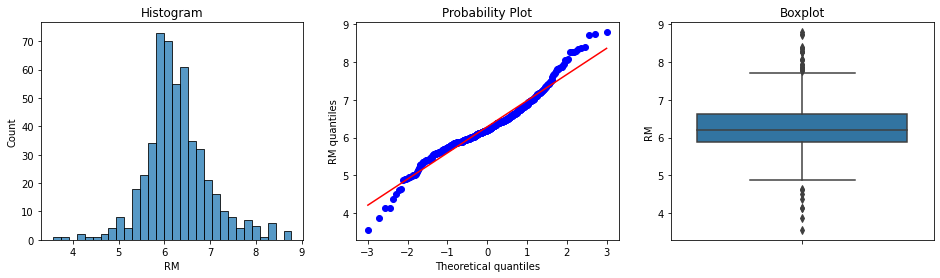

In [6]:
# Let's begin with the variable RM from the
# boston house dataset.

# RM is the average number of rooms per dwelling.

diagnostic_plots(boston, 'RM')

From the histogram and the Q-Q plot, we see that the variable RM shows roughly a Gaussian distribution. In the boxplot, we see some outliers, that is, the dots outside of the whiskers at both sides of the distribution.

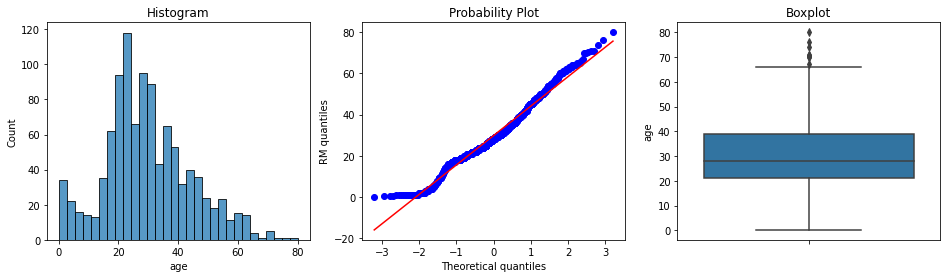

In [7]:
# Let's inspect the variable Age from the Titanic.

diagnostic_plots(titanic, 'age')

From the histogram and the Q-Q plot, we see that the variable approximates a Gaussian distribution. There is a deviation from the distribution towards the smaller values of age. In the boxplot, we can see some outliers, the dots outside of the whiskers at the top.

### Skewed variables

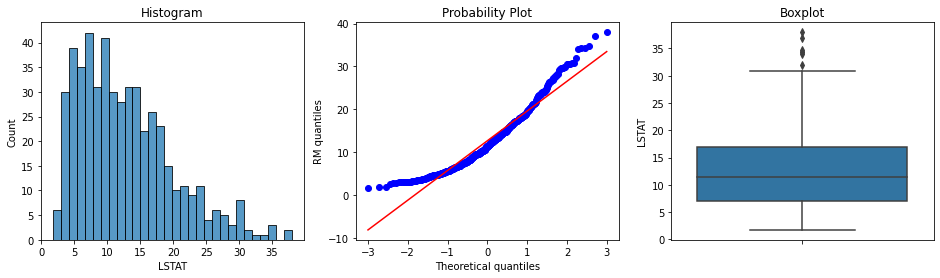

In [8]:
# Variable LSTAT from the boston house prices dataset.
# LSTAT is the % lower status of the population.

diagnostic_plots(boston, 'LSTAT')

LSTAT is not normally distributed, it is skewed with a tail to the right. According to the boxplot, there are some outliers at the right end of the distribution.

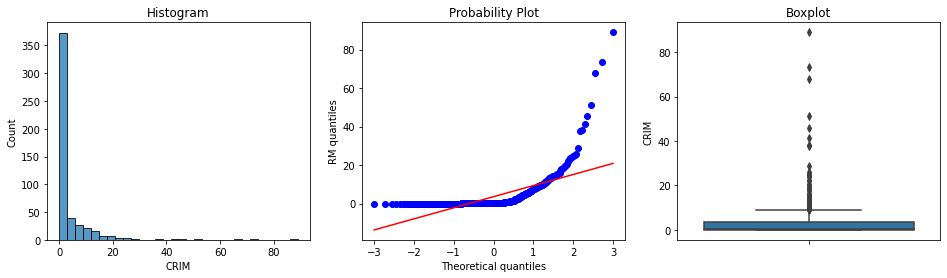

In [9]:
# Variable CRIM from the boston house prices dataset.
# CRIM is the per capita crime rate by town.

diagnostic_plots(boston, 'CRIM')

CRIM is heavily skewed, with a tail to the right. According to the boxplot, there are a few outliers at the right end of the distribution.

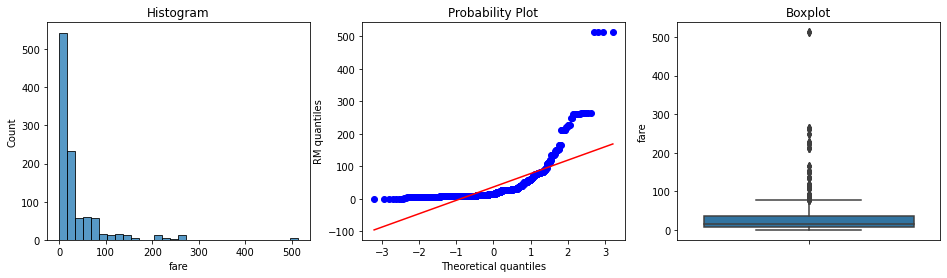

In [10]:
# Variable Fare from the Titanic dataset.
# Fare is the ticket price.

diagnostic_plots(titanic, 'fare')

Fare is also highly skewed, and shows some unusual values at the right end of its distribution.

In the next cells, we will identify outliers using the mean and the standard deviation for the variables RM and Age from the boston and titanic datasets, respectively. Then we will use the inter-quantile range to identify outliers for the variables LSTAT, CRIM and Fare from the boston and titanic datasets.

## Outlier detection

### Normally distributed variables

In [11]:
# Function to find upper and lower boundaries
# for normally distributed variables.


def find_normal_boundaries(df, variable):

    # Calculate the boundaries
    # for a Gaussian distribution.

    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

In [12]:
# calculate boundaries for RM

upper_boundary, lower_boundary = find_normal_boundaries(boston, 'RM')
upper_boundary, lower_boundary

(8.392485817597748, 4.176782957105809)

Values bigger than 8.4 or smaller than 4.2 occur very rarely in RM. Therefore, we can consider them outliers.

In [13]:
# Inspect the number and percentage of outliers in RM.

print('total number of houses: {}'.format(len(boston)))

print('houses with more than 8.4 rooms (right end outliers): {}'.format(
    len(boston[boston['RM'] > upper_boundary])))

print('houses with less than 4.2 rooms (left end outliers: {}'.format(
    len(boston[boston['RM'] < lower_boundary])))
print()
print('% right end outliers: {}'.format(
    len(boston[boston['RM'] > upper_boundary]) / len(boston)))

print('% left end outliers: {}'.format(
    len(boston[boston['RM'] < lower_boundary]) / len(boston)))

total number of houses: 506
houses with more than 8.4 rooms (right end outliers): 4
houses with less than 4.2 rooms (left end outliers: 4

% right end outliers: 0.007905138339920948
% left end outliers: 0.007905138339920948


Using Extreme Value Analysis we identified outliers at both ends of the distribution of RM. The percentage of outliers is small (1.4% considering the 2 tails together).

Let's move on to Age from the titanic dataset.

In [14]:
# Calculate boundaries for Age.

upper_boundary, lower_boundary = find_normal_boundaries(titanic, 'age')
upper_boundary, lower_boundary

(73.01943709155127, -13.315768766192416)

The upper boundary is 73 years, which means that passengers older than 73 were rare in the titanic. The lower boundary is negative. Because negative age does not exist, it only makes sense to look for outliers using the upper boundary.

In [15]:
# Let's look at the number and percentage of outliers.

print('total passengers: {}'.format(len(titanic)))

print('passengers older than 73: {}'.format(
    len(titanic[titanic['age'] > upper_boundary])))
print()
print('% of passengers older than 73: {}'.format(
    len(titanic[titanic['age'] > upper_boundary]) / len(titanic)))

total passengers: 1045
passengers older than 73: 3

% of passengers older than 73: 0.0028708133971291866


There were 2 passengers older than 73 on the titanic.

### Skewed variables

In [16]:
# Function to find upper and lower boundaries
# for skewed variables.


def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries
    # for skewed distributions

    # The parameter "distance" gives us the option to
    # estimate 1.5 times or 3 times the IQR when defining
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [17]:
# Find outliers with the IQR proximity rule.
# Here we use, IQR * 1.5, the standard metric.

# For LSTAT in the boston house prices dataset.

upper_boundary, lower_boundary = find_skewed_boundaries(boston, 'LSTAT', 1.5)
upper_boundary, lower_boundary

(31.962500000000006, -8.057500000000005)

In [18]:
# Let's look at the number and percentage of outliers
# for LSTAT.

print('total houses: {}'.format(len(boston)))

print('houses with LSTAT bigger than 32: {}'.format(
    len(boston[boston['LSTAT'] > upper_boundary])))
print()
print('% houses with LSTAT bigger than 32: {}'.format(
    len(boston[boston['LSTAT'] > upper_boundary])/len(boston)))

total houses: 506
houses with LSTAT bigger than 32: 7

% houses with LSTAT bigger than 32: 0.01383399209486166


The upper boundary is ~32. The lower boundary is negative. However, the variable LSTAT does not take negative values. Thus, outliers in LSTAT will only be found beyond the upper boundary. This coincides with what we observed in the boxplot earlier in the notebook. Outliers were only found at the right tail of LSTAT's distribution.

We observe 7 houses, 1.3 % of the dataset, with extremely high values for LSTAT.

In [19]:
# Find outliers with the IQR.
# Here, we use:  IQR * 3, I look for extremely high values.

upper_boundary, lower_boundary = find_skewed_boundaries(boston, 'CRIM', 3)
upper_boundary, lower_boundary

(14.462195000000001, -10.7030675)

In [20]:
# Let's look at the number and percentage of outliers
# for CRIM.

print('total houses: {}'.format(len(boston)))

print('houses with CRIM bigger than 14: {}'.format(
    len(boston[boston['CRIM'] > upper_boundary])))
print()
print('% houses with CRIM bigger than 14s: {}'.format(
    len(boston[boston['CRIM'] > upper_boundary]) / len(boston)))

total houses: 506
houses with CRIM bigger than 14: 30

% houses with CRIM bigger than 14s: 0.05928853754940711


When using the 3  times the inter-quartile range to find outliers, we find that ~6% of the houses show unusually high crime rate areas. For CRIM as well, the lower boundary is negative, so it only makes sense to use the upper boundary to find outliers, as the variable takes only positive values. This coincides with what we observed in CRIM's boxplot earlier in this notebook.

In [21]:
# Finally, identify outliers in Fare. 
# I will look again for extreme values
# using IQR * 3.

upper_boundary, lower_boundary = find_skewed_boundaries(titanic, 'fare', 3)
upper_boundary, lower_boundary

(117.85, -74.3)

In [22]:
# Let's look at the number and percentage of passengers
# who paid extremely high Fares.

print('total passengers: {}'.format(len(titanic)))

print('passengers who paid more than 117: {}'.format(
    len(titanic[titanic['fare'] > upper_boundary])))
print()
print('% passengers who paid more than 117: {}'.format(
    len(titanic[titanic['fare'] > upper_boundary])/len(titanic)))

total passengers: 1045
passengers who paid more than 117: 67

% passengers who paid more than 117: 0.06411483253588517


For Fare, as well as for all the other variables in this notebook which show a tail to the right, the lower boundary is negative. So we will use the upper boundary to find outliers. We observe that 6% of the values of the dataset fall above the boundary. 

**That is all for this demonstration. I hope you enjoyed the notebook, and I'll see you in the next one.**